In [1]:
import torch
import numpy as np
import pandas as pd
from torchinfo import summary
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

import sys
import argparse
import matplotlib.pyplot as plt

from utils import plot_predictions, loss_plot, ts_plot
from deepant import AnomalyDetector, DataModule, TrafficDataset, DeepAnt

import sklearn.metrics
from sklearn.metrics import roc_curve,roc_auc_score

import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
def config_args():
    
    parser = argparse.ArgumentParser(description='DeepAnt')
    
    parser.add_argument('--dataset', type=str, default='SWAT', help='dataset name')

    parser.add_argument('--epochs', type=int, default=40, help='number of epochs')
    parser.add_argument('--batch_size', type=int, default=32, help='number of batch')

    parser.add_argument('--window_size', type=int, default=10, help='window size for data loader')

    parser.add_argument('--id', type=str, default='', help='wpretrained model id')

    args = parser.parse_args()
    
    return args

In [3]:
def dataloader(dataset):
    if dataset == 'SWAT':
        df = pd.read_csv('./data/SWAT/test.csv')

        df['Timestamp'] = pd.to_datetime(df['Timestamp'].str.strip(), format='%d/%m/%Y %I:%M:%S %p')
        df.set_index('Timestamp', inplace=True)

        labels = [1 if label == 'Attack' else 0 for label in df['attack']]

        df = df.drop('attack', axis=1)

        return df, labels

    elif dataset == 'MACHINE':
        df = pd.read_csv('./data/MACHINE/test.csv')
        df = df.reset_index(drop=True)

        labels = df['attack']

        df = df.drop('attack', axis=1)

        return df, labels 
        
    else:
        print('dataset X')

In [4]:
def ROC(y_test,y_pred):
    fpr, tpr, tr = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    idx = np.argwhere(np.diff(np.sign(tpr - (1 - fpr)))).flatten()

    return tr[idx]

In [5]:
def cal_metrics(labels, outputs, window_size, threshold=None):

    # original label
    windows_labels=[]
    for i in range(len(labels) - window_size):
        windows_labels.append(list(np.int_(labels[i : i + window_size])))

    y_test = [ 1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]
    
    # predicted output
    y_pred = [np.array(item[1]) for item in outputs]

    # threshold
    if threshold is None:
        threshold = ROC(y_test, y_pred)

    y_pred_ = np.zeros(len(y_pred))
    y_pred_ = [1.0 if (i >= threshold) else 0.0 for i in y_pred]

    print('threshold :', threshold)
    print(sklearn.metrics.classification_report(y_test, y_pred_))

    return y_pred_

In [16]:
def plot_anomaly_features(data, pred, labels, window_size, num_features=8, ylim_margin=0.05):
    """
    data: (num_samples, num_features) pandas DataFrame
    pred: 모델이 anomaly라고 예측한 1차원 리스트 (1: anomaly, 0: 정상)
    labels: 실제 anomaly 라벨이 포함된 1차원 리스트 (1: anomaly, 0: 정상)
    window_size: 데이터를 삭제할 윈도우 크기
    num_features: 표시할 특성의 수
    ylim_margin: y축 범위 조정 비율 (0.05 = 5%)
    """
    num_samples = len(data)
    num_features_total = len(data.columns)
    
    if num_features > num_features_total:
        raise ValueError("Number of features to plot cannot exceed total number of features in data.")
    
    selected_features = np.random.choice(data.columns, num_features, replace=False)
    
    fig, axs = plt.subplots(num_features, 1, figsize=(15, 2 * num_features), sharex=True)
    
    time_indices = np.arange(num_samples)
    
    for i, feature_name in enumerate(selected_features):
        
        feature_data = data[feature_name]
        trimmed_data = feature_data[window_size:]
        trimmed_labels = labels[window_size:]
        trimmed_pred = pred[window_size:]
        
        trimmed_data = trimmed_data
        trimmed_labels = trimmed_labels
        trimmed_pred = trimmed_pred
        
        time = time_indices[:len(trimmed_data)]

        axs[i].plot(time, trimmed_data, color='black', label='Data', zorder=1)

        actual_anomaly_indices = [i for i in range(len(trimmed_labels)) if trimmed_labels[i] == 1]
        if actual_anomaly_indices:
            axs[i].scatter(time[actual_anomaly_indices], [trimmed_data[i] for i in actual_anomaly_indices], 
                           color='red', label='Actual Anomalies', marker='o', s=2, zorder=2)

        predicted_anomaly_indices = [i for i in range(len(trimmed_pred)) if trimmed_pred[i] == 1]
        if predicted_anomaly_indices:
            axs[i].scatter(time[predicted_anomaly_indices], [trimmed_data[i] for i in predicted_anomaly_indices], 
                           color='blue', label='Predicted Anomalies', marker='o', s=1.5, zorder=3)
        
        axs[i].set_ylabel(f'Feature: {feature_name}')
        axs[i].legend(loc='upper right', bbox_to_anchor=(1.17, 1), frameon=False)

        min_data = trimmed_data.min()
        max_data = trimmed_data.max()
        range_data = max_data - min_data
        margin = ylim_margin * range_data
        axs[i].set_ylim(min_data - margin, max_data + margin)
    
    axs[-1].set_xlabel("Time")
    plt.tight_layout()
    plt.show()

---

In [7]:
sys.argv = [''] 
sys.argv += ['--dataset', 'MACHINE', '--epochs', '40', '--batch_size', '64', 
             '--window_size', '10', '--id', 'DeepAnt-MACHINE']

In [8]:
args = config_args()

In [9]:
df, labels = dataloader(args.dataset) 
dataset = TrafficDataset(df, args.window_size)

In [10]:
target_idx = dataset.timestamp
feature_dim = df.shape[1]

In [11]:
checkpoint_path = f'results/{args.dataset}/{args.id}.ckpt'

<b>model

In [12]:
model = DeepAnt(feature_dim, args.window_size)
anomaly_detector = AnomalyDetector.load_from_checkpoint(checkpoint_path, model = model)

In [13]:
data_module = DataModule(df, args.window_size)
model_checkpoint = ModelCheckpoint(
    dirpath = 'results/' + args.dataset,
    save_last = True,
    save_top_k = 1,
    verbose = True,
    monitor = 'train_loss', 
    mode = 'min'
)

In [14]:
trainer = pl.Trainer(max_epochs = args.epochs, # ^^epochs
                    accelerator = "gpu",
                    devices = 1, 
                    callbacks = [model_checkpoint]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [15]:
outputs = trainer.predict(anomaly_detector, data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

In [17]:
y_pred = cal_metrics(labels, outputs, args.window_size)

threshold : [0.5703318]
              precision    recall  f1-score   support

         0.0       0.64      0.77      0.70      2176
         1.0       0.86      0.77      0.81      4001

    accuracy                           0.77      6177
   macro avg       0.75      0.77      0.75      6177
weighted avg       0.78      0.77      0.77      6177



In [20]:
y_pred = cal_metrics(labels, outputs, args.window_size, threshold=0.6)

threshold : 0.6
              precision    recall  f1-score   support

         0.0       0.60      0.82      0.69      2176
         1.0       0.87      0.70      0.78      4001

    accuracy                           0.74      6177
   macro avg       0.74      0.76      0.73      6177
weighted avg       0.78      0.74      0.75      6177



---

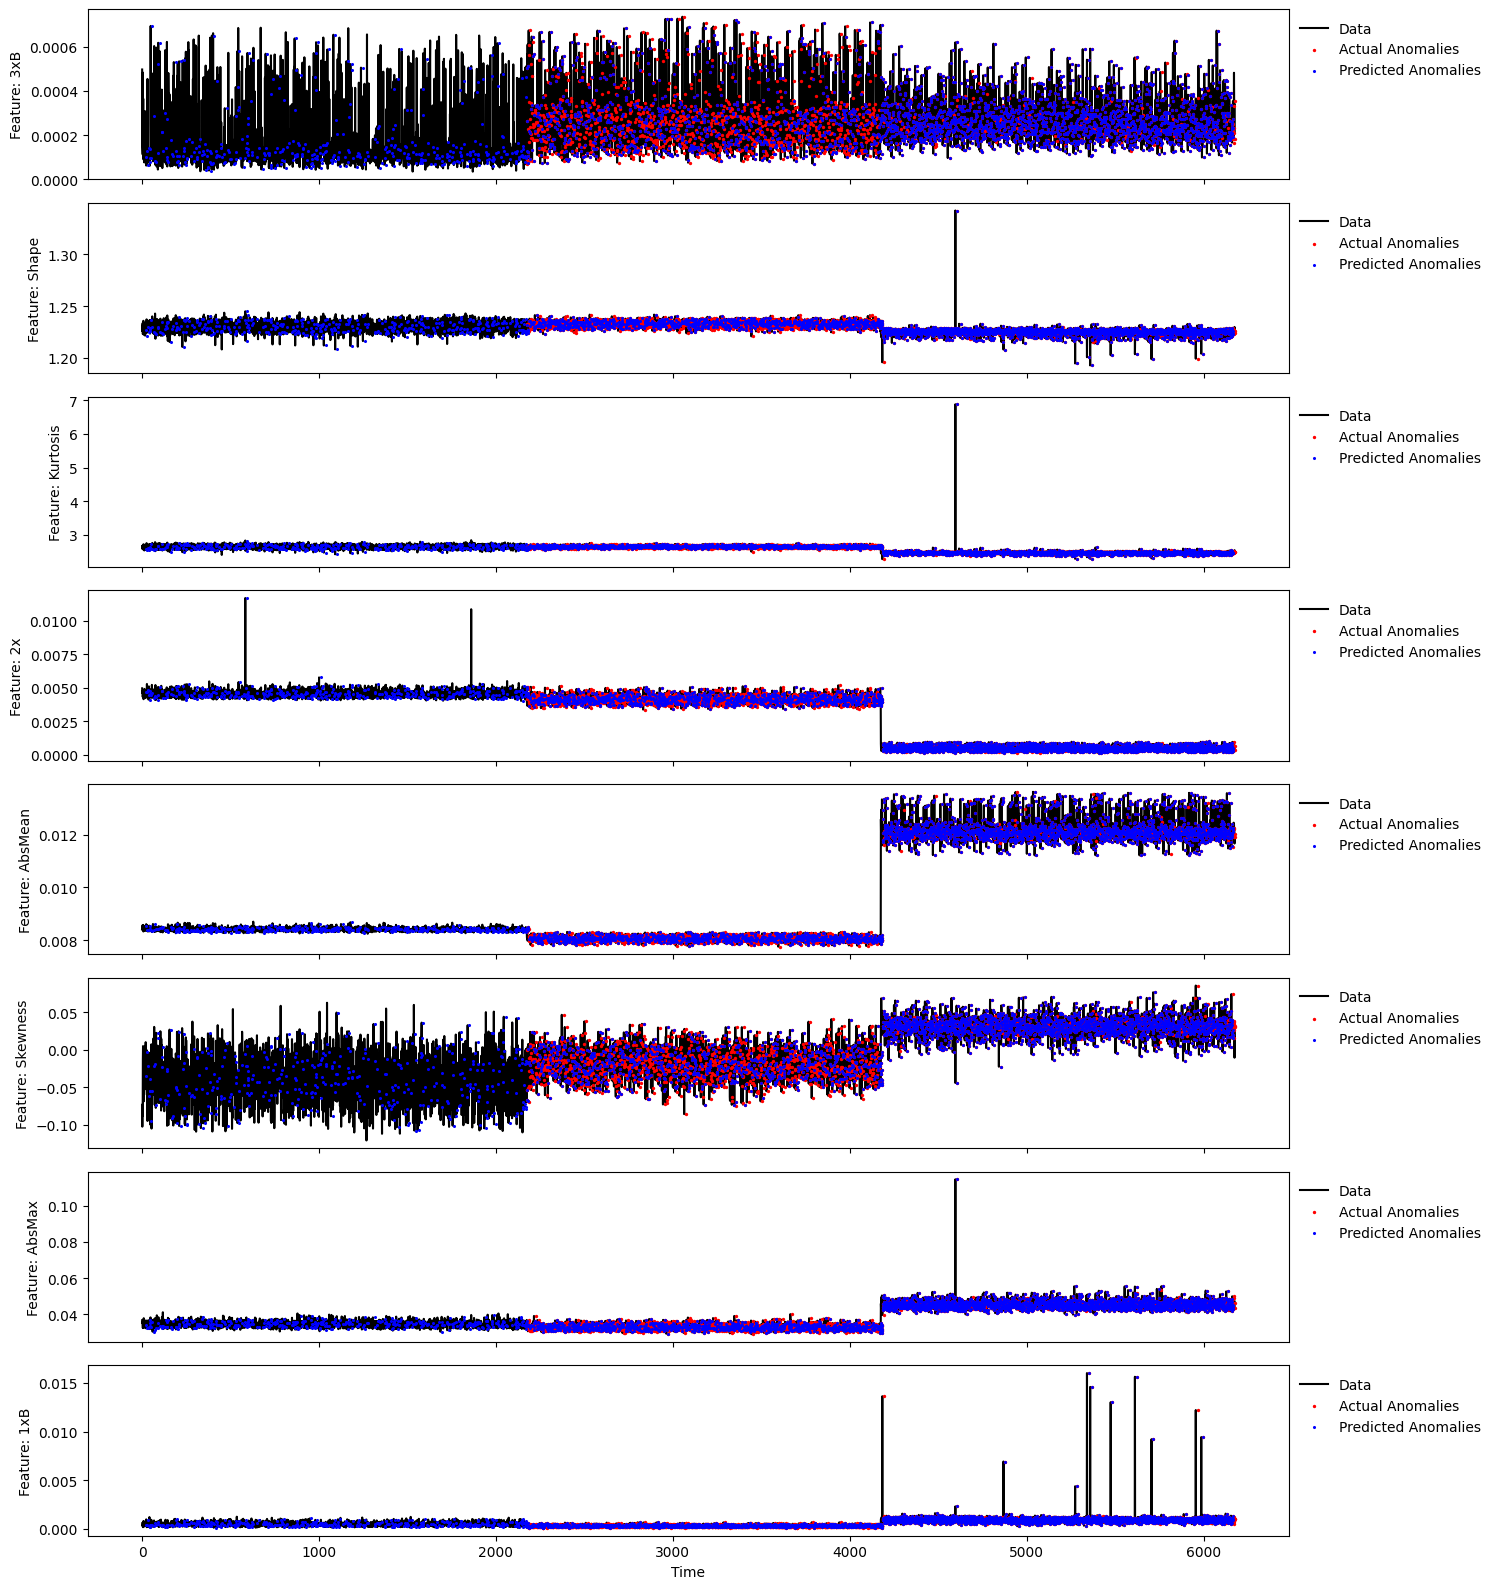

In [21]:
plot_anomaly_features(df, y_pred, np.array(labels), args.window_size, num_features=8)